# Imports

In [5]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport

# Download

In [6]:
## download the dataset
# Directory of the raw data files 
_data_root = './data/Diabetes'
# Path to the raw training data
_data_filepath = os.path.join(_data_root, 'Diabetes.csv')
# Download data
os.makedirs(_data_root, exist_ok=True)
if not os.path.isfile(_data_filepath):
    #https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/
    url = 'https://docs.google.com/uc?export= \
    download&confirm={{VALUE}}&id=1k5-1caezQ3zWJbKaiMULTGq-3sz6uThC'
    r = requests.get(url, allow_redirects=True, stream=True)
    open(_data_filepath, 'wb').write(r.content)

In [7]:
df = pd.read_csv('./data/Diabetes/Diabetes.csv')

In [8]:
df.head() 

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Split data

In [9]:
# Split: 70% train, 30% temp (which will be split into 15% val + 15% test)
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df['readmitted'])

# Split temp into 50% validation and 50% test (each 15% of original)
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df['readmitted'])

print(f"Training: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Training: 71236 (70.0%)
Validation: 15265 (15.0%)
Test: 15265 (15.0%)


# Analyze

In [10]:
# Basic information about the training data
print("=" * 60)
print("BASIC DATASET INFORMATION")
print("=" * 60)
print(f"Dataset shape: {train_df.shape}")
print(f"Number of samples: {train_df.shape[0]:,}")
print(f"Number of features: {train_df.shape[1]}")
print(f"\nMemory usage: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

BASIC DATASET INFORMATION
Dataset shape: (71236, 50)
Number of samples: 71,236
Number of features: 50

Memory usage: 154.69 MB


In [11]:
# Column data types
print("\n" + "=" * 60)
print("DATA TYPES")
print("=" * 60)
print(train_df.dtypes.value_counts())
print("\nColumn types breakdown:")
print(f"Numerical columns: {len(train_df.select_dtypes(include=[np.number]).columns)}")
print(f"Categorical columns: {len(train_df.select_dtypes(include=['object']).columns)}")


DATA TYPES
object    37
int64     13
Name: count, dtype: int64

Column types breakdown:
Numerical columns: 13
Categorical columns: 37


In [12]:
# Missing values analysis
print("\n" + "=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

# Check for standard missing values
missing_standard = train_df.isnull().sum()
print(f"Standard NaN values: {missing_standard.sum()}")

# Check for '?' as missing indicator
missing_question = (train_df == '?').sum()
print(f"'?' as missing values: {missing_question.sum()}")

# Combine both
if missing_question.sum() > 0:
    print("\nColumns with '?' values:")
    print(missing_question[missing_question > 0].sort_values(ascending=False))
    print("\nPercentage of '?' per column:")
    pct_missing = (missing_question[missing_question > 0] / len(train_df) * 100).sort_values(ascending=False)
    for col, pct in pct_missing.items():
        print(f"  {col}: {pct:.2f}%")


MISSING VALUES ANALYSIS
Standard NaN values: 126871
'?' as missing values: 134963

Columns with '?' values:
weight               68986
medical_specialty    34930
payer_code           28178
race                  1621
diag_3                 989
diag_2                 244
diag_1                  15
dtype: int64

Percentage of '?' per column:
  weight: 96.84%
  medical_specialty: 49.03%
  payer_code: 39.56%
  race: 2.28%
  diag_3: 1.39%
  diag_2: 0.34%
  diag_1: 0.02%


In [13]:
# Duplicate records
print("\n" + "=" * 60)
print("DUPLICATE RECORDS")
print("=" * 60)
duplicates = train_df.duplicated().sum()
print(f"Total duplicate rows: {duplicates}")
print(f"Percentage: {(duplicates/len(train_df)*100):.2f}%")

# Check duplicates excluding IDs
if 'encounter_id' in train_df.columns and 'patient_nbr' in train_df.columns:
    duplicates_no_id = train_df.drop(columns=['encounter_id', 'patient_nbr']).duplicated().sum()
    print(f"Duplicates (excluding IDs): {duplicates_no_id}")


DUPLICATE RECORDS
Total duplicate rows: 0
Percentage: 0.00%
Duplicates (excluding IDs): 0



TARGET VARIABLE ANALYSIS - 'readmitted'

Value counts:
readmitted
NO     38405
>30    24881
<30     7950
Name: count, dtype: int64

Percentage distribution:
readmitted
NO     53.912348
>30    34.927565
<30    11.160088
Name: proportion, dtype: float64


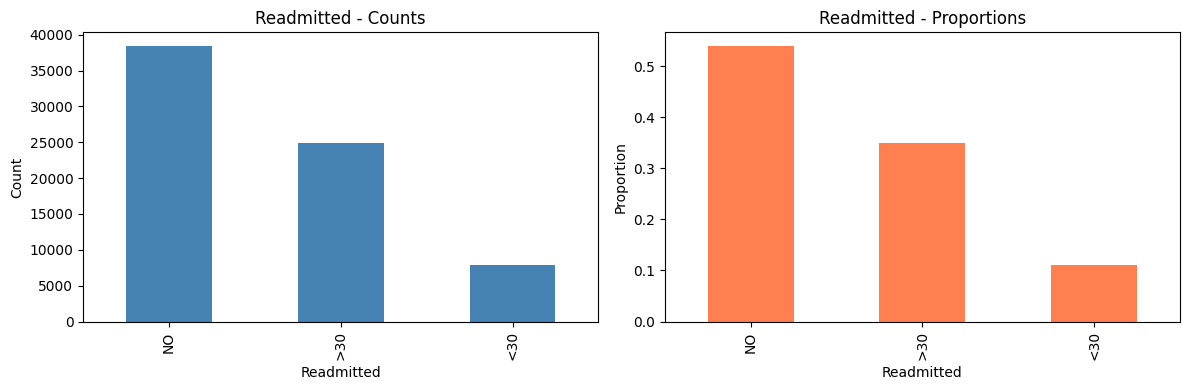

In [14]:
# Target variable analysis
print("\n" + "=" * 60)
print("TARGET VARIABLE ANALYSIS - 'readmitted'")
print("=" * 60)
print("\nValue counts:")
print(train_df['readmitted'].value_counts())
print("\nPercentage distribution:")
print(train_df['readmitted'].value_counts(normalize=True) * 100)

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

train_df['readmitted'].value_counts().plot(kind='bar', ax=ax[0], color='steelblue')
ax[0].set_title('Readmitted - Counts')
ax[0].set_xlabel('Readmitted')
ax[0].set_ylabel('Count')

train_df['readmitted'].value_counts(normalize=True).plot(kind='bar', ax=ax[1], color='coral')
ax[1].set_title('Readmitted - Proportions')
ax[1].set_xlabel('Readmitted')
ax[1].set_ylabel('Proportion')

plt.tight_layout()
plt.show()

In [15]:
# Numerical features analysis

print("\n" + "=" * 60)
print("NUMERICAL FEATURES ANALYSIS")
print("=" * 60)

numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")

print("\nDescriptive statistics:")
train_df[numerical_cols].describe()


NUMERICAL FEATURES ANALYSIS
Numerical columns (13): ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

Descriptive statistics:


,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,7.123600e+04,7.123600e+04,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000
mean,1.651772e+08,5.421577e+07,2.020116,3.721250,5.743500,4.394660,43.112612,1.342523,16.016452,0.371104,0.195800,0.635353,7.418103
std,1.027123e+08,3.866893e+07,1.441682,5.291709,4.050373,2.979942,19.658896,1.705587,8.130801,1.269937,0.864571,1.269287,1.930480
min,1.573800e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.471072e+07,2.340213e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523227e+08,4.520375e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.307948e+08,8.742009e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,63.000000,19.000000,16.000000


In [16]:
# Categorical features analysis
print("\n" + "=" * 60)
print("CATEGORICAL FEATURES ANALYSIS")
print("=" * 60)

categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols[:10]}...")  # Show first 10
print(f"\nTotal categorical columns: {len(categorical_cols)}")

print("\nUnique values per categorical column:")
cat_unique = {}
for col in categorical_cols:
    n_unique = train_df[col].nunique()
    cat_unique[col] = n_unique
    
# Sort by number of unique values
cat_unique_sorted = dict(sorted(cat_unique.items(), key=lambda x: x[1], reverse=True))
for col, n_unique in list(cat_unique_sorted.items())[:15]:  # Show top 15
    print(f"  {col}: {n_unique} unique values")


CATEGORICAL FEATURES ANALYSIS
Categorical columns (37): ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum']...

Total categorical columns: 37

Unique values per categorical column:
  diag_3: 746 unique values
  diag_2: 692 unique values
  diag_1: 685 unique values
  medical_specialty: 69 unique values
  payer_code: 18 unique values
  age: 10 unique values
  weight: 10 unique values
  race: 6 unique values
  metformin: 4 unique values
  repaglinide: 4 unique values
  nateglinide: 4 unique values
  glimepiride: 4 unique values
  glipizide: 4 unique values
  glyburide: 4 unique values
  pioglitazone: 4 unique values


In [17]:
# Check for constant/low variance features
print("\n" + "=" * 60)
print("LOW VARIANCE FEATURES")
print("=" * 60)

# Columns with only 1 unique value
constant_cols = []
low_variance_cols = []

for col in train_df.columns:
    n_unique = train_df[col].nunique()
    if n_unique == 1:
        constant_cols.append(col)
    elif n_unique == 2:
        low_variance_cols.append((col, n_unique))

print(f"Constant features (only 1 value): {len(constant_cols)}")
if constant_cols:
    print(f"  {constant_cols}")

print(f"\nBinary features (only 2 values): {len(low_variance_cols)}")
if low_variance_cols:
    for col, n in low_variance_cols[:10]:
        print(f"  {col}: {train_df[col].unique()}")


LOW VARIANCE FEATURES
Constant features (only 1 value): 3
  ['troglitazone', 'examide', 'citoglipton']

Binary features (only 2 values): 8
  acetohexamide: ['No' 'Steady']
  tolbutamide: ['No' 'Steady']
  glipizide-metformin: ['No' 'Steady']
  glimepiride-pioglitazone: ['No' 'Steady']
  metformin-rosiglitazone: ['No' 'Steady']
  metformin-pioglitazone: ['No' 'Steady']
  change: ['Ch' 'No']
  diabetesMed: ['Yes' 'No']



CORRELATION ANALYSIS
No highly correlated features found (threshold: 0.8)


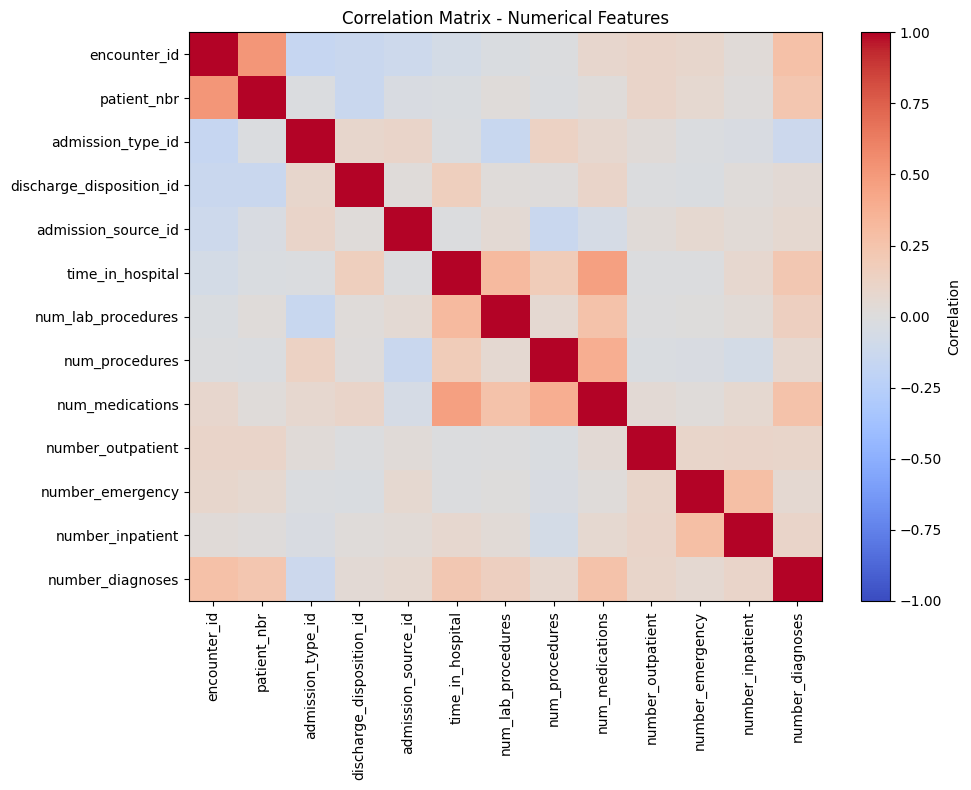

In [18]:
# Correlation analysis (numerical features)
print("\n" + "=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

if len(numerical_cols) > 1:
    # Calculate correlation matrix
    correlation_matrix = train_df[numerical_cols].corr()
    
    # Find highly correlated pairs
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.8:
                high_corr_pairs.append((
                    correlation_matrix.columns[i],
                    correlation_matrix.columns[j],
                    correlation_matrix.iloc[i, j]
                ))
    
    if high_corr_pairs:
        print("Highly correlated features (|correlation| > 0.8):")
        for col1, col2, corr in high_corr_pairs:
            print(f"  {col1} <-> {col2}: {corr:.3f}")
    else:
        print("No highly correlated features found (threshold: 0.8)")
    
    # Visualize correlation matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    plt.colorbar(label='Correlation')
    plt.xticks(range(len(numerical_cols)), numerical_cols, rotation=90)
    plt.yticks(range(len(numerical_cols)), numerical_cols)
    plt.title('Correlation Matrix - Numerical Features')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numerical features for correlation analysis")

In [19]:
# Sample data inspection
print("\n" + "=" * 60)
print("SAMPLE DATA INSPECTION")
print("=" * 60)

print("First 5 rows:")
display(train_df.head())

print("\nRandom 5 rows:")
display(train_df.sample(5, random_state=42))

print("\nColumn names:")
print(train_df.columns.tolist())


SAMPLE DATA INSPECTION
First 5 rows:


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
26922,88346340,2488608,Caucasian,Male,[60-70),?,1,2,6,3,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
28106,92001408,52133202,Caucasian,Male,[70-80),[100-125),2,6,1,7,...,No,No,No,No,No,No,No,No,Yes,>30
60528,169424316,40945509,Caucasian,Female,[70-80),?,3,2,1,7,...,No,Up,No,No,No,No,No,Ch,Yes,>30
85997,272987082,38850777,Caucasian,Female,[50-60),?,1,1,7,1,...,No,No,No,No,No,No,No,No,Yes,NO
49987,150600612,72738225,Caucasian,Female,[80-90),?,1,6,7,6,...,No,Down,No,No,No,No,No,Ch,Yes,NO



Random 5 rows:


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
20015,70946670,7889868,Caucasian,Female,[70-80),?,2,1,4,2,...,No,No,No,No,No,No,No,No,No,NO
101576,441390386,141038771,Caucasian,Female,[60-70),?,3,3,1,6,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
40048,124550064,42067044,Caucasian,Male,[80-90),?,1,3,7,6,...,No,Down,No,No,No,No,No,Ch,Yes,>30
91058,304288598,122255033,Caucasian,Male,[70-80),?,2,3,1,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
24027,81756024,100489734,Caucasian,Female,[50-60),[75-100),3,1,1,10,...,No,No,No,No,No,No,No,No,Yes,>30



Column names:
['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


In [20]:
# Detailed analysis of specific problematic columns
print("\n" + "=" * 60)
print("DETAILED COLUMN ANALYSIS")
print("=" * 60)

# Analyze 'weight' column (we saw '?' in the preview)
if 'weight' in train_df.columns:
    print("\n'weight' column:")
    print(f"  Unique values: {train_df['weight'].nunique()}")
    print(f"  Value counts:\n{train_df['weight'].value_counts()}")
    
# Analyze 'race' column
if 'race' in train_df.columns:
    print("\n'race' column:")
    print(f"  Unique values: {train_df['race'].nunique()}")
    print(f"  Value counts:\n{train_df['race'].value_counts()}")

# Analyze 'age' column (categorical age ranges)
if 'age' in train_df.columns:
    print("\n'age' column:")
    print(f"  Unique values: {train_df['age'].nunique()}")
    print(f"  Value counts:\n{train_df['age'].value_counts().sort_index()}")


DETAILED COLUMN ANALYSIS

'weight' column:
  Unique values: 10
  Value counts:
weight
?            68986
[75-100)       944
[50-75)        643
[100-125)      421
[125-150)      103
[25-50)         69
[0-25)          34
[150-175)       27
[175-200)        7
>200             2
Name: count, dtype: int64

'race' column:
  Unique values: 6
  Value counts:
race
Caucasian          53373
AfricanAmerican    13351
?                   1621
Hispanic            1428
Other               1031
Asian                432
Name: count, dtype: int64

'age' column:
  Unique values: 10
  Value counts:
age
[0-10)        104
[10-20)       495
[20-30)      1165
[30-40)      2650
[40-50)      6785
[50-60)     12080
[60-70)     15801
[70-80)     18179
[80-90)     12037
[90-100)     1940
Name: count, dtype: int64


# Analysis EDA

In [ ]:
print("Generating comprehensive data analysis report...")
profile = ProfileReport(
    train_df, 
    title="Diabetes Training Data - Full Analysis",
    explorative=True
)

# Save to file
profile.to_file("./data/Diabetes/train_analysis_report.html")
print("Report saved to: ./data/Diabetes/train_analysis_report.html")

Generating comprehensive data analysis report...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

# DAG 1: Download data

# DAG 2: Split data

# DAG 3: Store raw data

# DAG 4: Clean training data

# DAG 5: Store clean data

# DAG 6: Training models

# DAG 7: Select best model (with validation data)

# DAG 8: Publish in production